In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%pip install git+https://github.com/metadriverse/metadrive.git
!pip install stable-baselines3  # For PPO experiments
!pip install gym  # Ensure gym is installed


  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-5k3z8iif
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-5k3z8iif
  Resolved https://github.com/metadriverse/metadrive.git to commit b908149e422f2e7715207ca1eb81380342de5681
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00
  Created wheel for metadrive-simulator: filename=metadrive_simulator-0.4.3-py3-none-any.whl size=55022091 sha256=fb83c

In [11]:
!apt-get install -y xvfb python-opengl ffmpeg

!pip install pyvirtualdisplay

!sudo apt-get update
!sudo apt-get install -y xvfb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,196 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]


In [1]:
import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from datetime import datetime
import torch
import pandas as  pd

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [2]:
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0
        self.reward_dict = {}

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
            # self.reward_dict[self.num_timesteps] = self.rewards[-1]
        return True


In [4]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 2, "traffic_density": 0.0, "random_lane_width": False, "use_render": render,
                  # "num_agents": 1,
        # "is_multi_agent": False
                            #  "out_of_road_penalty": 30.0,  # Increased penalty
                #  "out_of_road_cost":


                 },
        "medium": {"map": 3, "traffic_density": 0.3, "random_lane_width": True, "use_render": render,

                              #  "out_of_road_penalty": 30.0,  # Increased penalty

                   },
        "hard": {"map": 4, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

In [5]:
def train_agent_with_transfer(env, timesteps=1000, model=None, callbacks=None, checkpoint_dir="./"):
    if model is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = PPO("MlpPolicy", env, verbose=2, n_steps=4096) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger = PerformanceLogger()
    # model.learn(total_timesteps=100000, callback=checkpoint_callback)
    checkpoint_callback = CheckpointCallback(
        save_freq=200,
        save_path=checkpoint_dir,
        name_prefix='ppo_model'
    )
    logger.reset()
    # logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=[logger, checkpoint_callback])
    print('loggerrewards', logger.rewards)
    return model, logger

In [6]:
def plot_performance(logger, title= 'Agent Performance', save_path=None):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()

    # if save_path:
    plt.savefig(os.path.join(save_path, "training_rewards.png"))
    plt.show()

In [19]:
def init_dirs(trial_name, difficulty):
    trial_dir = os.path.join('trials', trial_name)
    log_dir = os.path.join(trial_name, difficulty, 'logs')
    checkpoint_dir = os.path.join(trial_dir,  difficulty, 'checkpoints')
    best_model_dir = os.path.join(trial_dir,  difficulty, 'best_model')
    gif_dir = os.path.join(trial_dir, difficulty, 'gifs')
    os.makedirs(trial_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(best_model_dir, exist_ok=True)
    os.makedirs(gif_dir, exist_ok=True)
    return trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir

def get_callbacks(checkpoint_dir, best_model_dir, log_dir, eval_env):
    logger = PerformanceLogger()
    # model.learn(total_timesteps=100000, callback=checkpoint_callback)
    checkpoint_callback = CheckpointCallback(
        save_freq=10_000,
        save_path=checkpoint_dir,
        name_prefix='ppo_model'
    )
    # TODO: get filepaths right
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=best_model_dir,
        log_path=log_dir,
        eval_freq=1000,  # Evaluate every 10,000 steps
        n_eval_episodes=5,  # Number of episodes per evaluation
        deterministic=True,
        render=False
    )
    return eval_callback, checkpoint_callback, logger

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
from google.cloud import storage
def upload_folder_to_gcs(local_folder, bucket_name, gcs_prefix):
    """
    Uploads the contents of a local folder (including subdirectories) to a GCS bucket,
    preserving the folder structure under a given prefix.

    Args:
        local_folder (str): Path to the local folder.
        bucket_name (str): Name of the GCS bucket.
        gcs_prefix (str): Prefix for the uploaded files in the bucket.

    Returns:
        None
    """
    # Initialize the GCS client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Walk through the local folder
    for root, dirs, files in os.walk(local_folder):
        for file_name in files:
            # Get the full local path
            local_path = os.path.join(root, file_name)

            # Construct the relative path in GCS
            relative_path = os.path.relpath(local_path, local_folder)
            gcs_path = os.path.join(gcs_prefix, relative_path).replace('\\', '/')  # Ensure GCS path is POSIX-style

            # Upload the file
            blob = bucket.blob(gcs_path)
            blob.upload_from_filename(local_path)
            print(f"Uploaded {local_path} to gs://{bucket_name}/{gcs_path}")
# local_folder = "./trials"
# bucket_name = "snap-chef-recipe"
# gcs_prefix = "rl-final-project"

# # Call the function
# upload_folder_to_gcs(local_folder, bucket_name, gcs_prefix)

In [21]:
# # Curriculum experiment without transfer learning
# def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000, ):
#     results = []
#     models = []
#     for difficulty in difficulty_order:
#         print(f"Training on {difficulty} difficulty (No Transfer)...")
#         env = create_environment(difficulty, render=False)
#         try:
#             model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
#             results.append((difficulty, logger))
#             models.append((difficulty, model))
#         finally:
#             env.close()

#     # Plot performance for each difficulty
#     for difficulty, logger in results:
#         print(f"Performance for {difficulty} difficulty:")
#         plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
#     return results,  models

In [22]:
from IPython import display

def create_gif(env, model, gif_dir):
    obs, _ = env.reset()
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        if isinstance(env, Monitor):
            e = env.env
        else:
            e = env
        ret = e.render(mode="topdown",
                        screen_record=True,
                        window=False,
                        screen_size=(600, 600),
                        camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif(os.path.join(gif_dir, 'demo.gif'))
    img = display.Image(filename=os.path.join(gif_dir, 'demo.gif'))
    # display(img)
    return img

In [23]:
def run_trial(trial_name, difficulty, model, transfer, timesteps_per_difficulty):
    trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir = init_dirs(trial_name, difficulty)
    eval_env = create_environment(difficulty, render=False, monitor=False)

    print(f"Training on {difficulty} difficulty (With Transfer={transfer})...")
    env = create_environment(difficulty, render=False)
    try:
        eval_callback, checkpoint_callback, _ = get_callbacks(checkpoint_dir, best_model_dir, log_dir, eval_env)
        # try:
        #   x=evaluate_model(model, eval_env, num_episodes=10, max_timesteps_per_episode=1000)
        #   rews = pd.DataFrame(x)
        #   pd.to_csv(os.path.join(trial_dir, 'test_rewards_pre_training.csv'), index=False)
        # except Exception as e:
        #   print(f"Error during gif creation/test eval with ", e)
        model, logger = train_agent_with_transfer(env,
                                                  model=model,
                                                  timesteps=timesteps_per_difficulty,
                                                  callbacks=[ checkpoint_callback], # eval_callback,
                                                  checkpoint_dir=checkpoint_dir


        )
        df = pd.DataFrame(logger[0][1].timesteps, logger[0][1].rewards)
        df.columns = ["timesteps", "rewards"]
        df.to_csv(os.path.join(best_model_dir, "training_rewards.csv"))
        # model = PPO.load(os.path.join(best_model_dir, 'best_model'))
    except Exception as e:
        print(f"Error during training on {difficulty} difficulty: {e}")
    finally:
        env.close()
        try:
          create_gif(eval_env, model, gif_dir)
          x=evaluate_model(model, eval_env, num_episodes=10, max_timesteps_per_episode=1000)
          rews = pd.DataFrame(x)
          rews.to_csv(os.path.join(best_model_dir, 'test_rewards_post_training.csv'), index=False)
        except Exception as e:
          print(f"Error during gif creation/test eval with ", e)
        eval_env.close()
    # print("after trail rewards ", logger.rewards)
    # Plot performance for each difficulty
    # print(f"Performance for {difficulty} difficulty:"
    return logger, model, None

In [24]:
# Curriculum experiment with transfer learning
def curriculum_experiment(difficulty_order, timesteps_per_difficulty=1000, transfer=True, trial_name=None, model=None):
    if trial_name is None:
        trial_name = datetime.now().strftime("%Y%m%d-%H%M%S")
    results = []
    models = []
    final_models = []

    for difficulty in difficulty_order:
        trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir = init_dirs(trial_name, difficulty)
        result, model, final_model = run_trial(trial_name, difficulty, model,transfer, timesteps_per_difficulty)
        results.append((difficulty, result))
        models.append((difficulty, model))
        final_models.append((difficulty, final_model))
        if transfer:
            model = final_model
        else:
            model = None
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(result, f"Performance on {difficulty} (With Transfer={transfer})", best_model_dir)
    return results, models, final_models

In [25]:
def evaluate_model(model, env, num_episodes=10, max_timesteps_per_episode=1000):
    """
    Evaluate a trained model in the given environment.

    Parameters:
    - model: The trained RL model to evaluate.
    - env: The environment to evaluate the model in.
    - num_episodes: Number of episodes to run for evaluation.
    - max_timesteps_per_episode: Maximum timesteps per episode.

    Returns:
    - results: A list of dictionaries containing total reward and termination reason for each episode.
    """
    results = []

    for episode in range(num_episodes):
      obs, _ = env.reset()
      total_reward = 0
      termination_reason = None
      for i in range(1_000):
          action, _states = model.predict(obs, deterministic=True)
          obs, reward, terminated, truncated, info = env.step(action)
          total_reward += reward
          # total_reward += reward
          if isinstance(env, Monitor):
              e = env.env
          else:
              e = env
          ret = e.render(mode="topdown",
                          screen_record=True,
                          window=False,
                          screen_size=(600, 600),
                          camera_position=(50, 50))


          if terminated or truncated:
              if info.get("arrive_dest", False):
                  termination_reason = "Destination Reached"
              elif info.get("crash", False):
                  termination_reason = "Collision"
              elif info.get("out_of_road", False):
                  termination_reason = "Off Road"
              else:
                  termination_reason = "Other"
              break

      results.append({
          "episode": episode + 1,
          "total_reward": total_reward,
          "termination_reason": termination_reason
      })

    return results


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe


Training on easy difficulty (With Transfer=False)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.85e+03 |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 216      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 4096     |
---------------------------------
loggerrewards [0.011429878044643849]


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max 

Training on medium difficulty (With Transfer=False)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 958      |
|    ep_rew_mean     | 7.34     |
| time/              |          |
|    fps             | 26       |
|    iterations      | 1        |
|    time_elapsed    | 152      |
|    total_timesteps | 4096     |
---------------------------------
loggerrewards [0.009217491108839182]


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


Performance for easy difficulty:


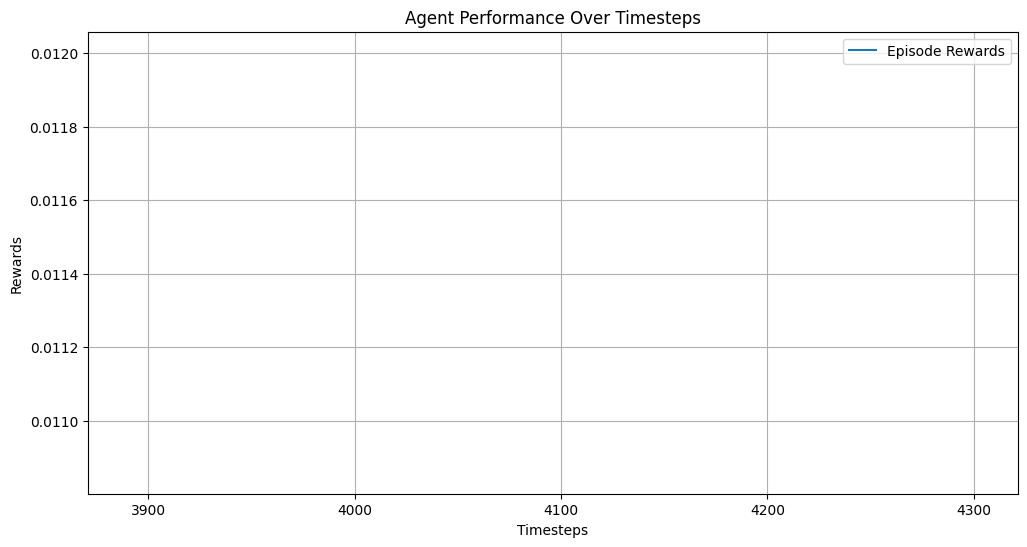

Performance for medium difficulty:


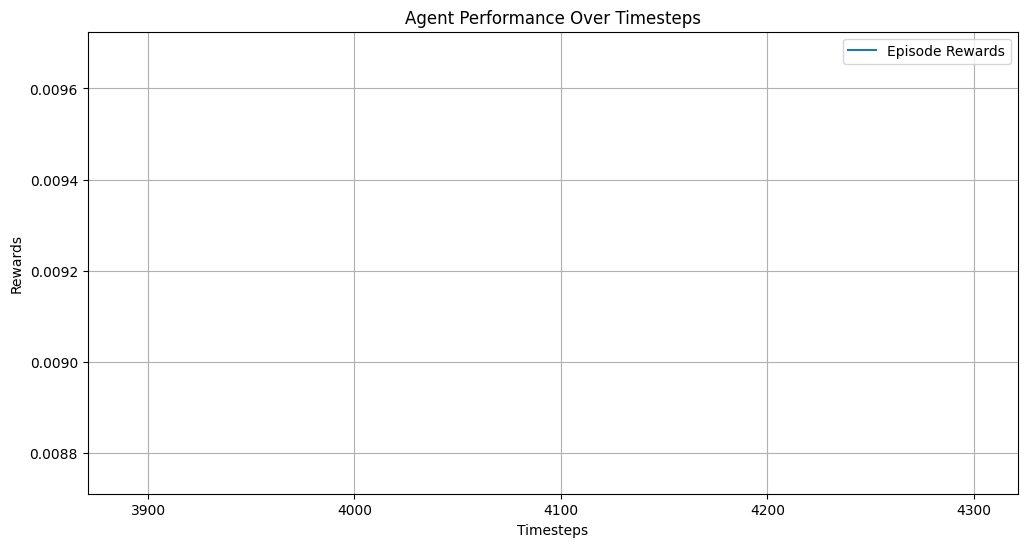

In [26]:
time_steps = 200
difficulty_order = ["easy", "medium" ]#  , "medium", "hard"
results, models, final_models = curriculum_experiment(difficulty_order, timesteps_per_difficulty=time_steps, transfer=False, trial_name="easy_med_hard_no_trans")

In [37]:
from google.colab import userdata
import os
from datetime import datetime
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = userdata.get('GOOGLE_APPLICATION_CREDENTIALS')
print(userdata.get('GOOGLE_APPLICATION_CREDENTIALS'))
from google.cloud import storage

# Get the credentials file path from the environment variable
credentials_path = os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')

# Authenticate using the credentials file
storage_client = storage.Client.from_service_account_json(credentials_path)

# Now you can use the storage_client to access Google Cloud Storage resources
# ... (rest of your code)

/content/drive/MyDrive/gcreds.json


In [38]:
upload_folder_to_gcs("trials", "snap-chef-recipe", "rl-final-project")


Uploaded trials/easy_med_hard_no_trans/test_rewards_post_training.csv to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/test_rewards_post_training.csv
Uploaded trials/easy_med_hard_no_trans/easy/gifs/demo.gif to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/easy/gifs/demo.gif
Uploaded trials/easy_med_hard_no_trans/medium/gifs/demo.gif to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/medium/gifs/demo.gif


In [86]:
models[0][1]

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


In [93]:
import pandas as pd


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episode,total_reward,termination_reason
0,1,10.047918,Off Road
1,2,10.047918,Off Road
2,3,10.047918,Off Road
3,4,10.047918,Off Road
4,5,10.047918,Off Road
5,6,10.047918,Off Road
6,7,10.047918,Off Road
7,8,10.047918,Off Road
8,9,10.047918,Off Road
9,10,10.047918,Off Road


In [39]:
results[0][1].rewards

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.01116945878004601]

In [35]:
trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir = init_dirs(trial_name, difficulty)
model = models[0][1]
env = create_environment('easy', render=False, monitor=False)
try:
  gif = create_gif(env, model, gif_dir)
finally:
  env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


In [28]:
models

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('easy', <stable_baselines3.ppo.ppo.PPO at 0x7c9de5a9b7c0>),
 ('medium', <stable_baselines3.ppo.ppo.PPO at 0x7c9de5a179a0>)]

In [ ]:

difficulty_order = ["easy", "medium", "hard"]
results, models, final_models = curriculum_experiment(difficulty_order, timesteps_per_difficulty=time_steps*3, transfer=False, trial_name="easy_med_hard_no_trans")

In [52]:
results, models, final_models = curriculum_experiment(difficulty_order, timesteps_per_difficulty=500, transfer=True, trial_name="easy_med_hard_trans")


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (With Transfer=True)...
Using cpu device
Wrapping the env in a DummyVecEnv.
Error during training on easy difficulty: 'str' object has no attribute 'init_callback'


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer=True)...
Using cpu device
Wrapping the env in a DummyVecEnv.
Error during training on medium difficulty: 'str' object has no attribute 'init_callback'
Performance for easy difficulty:
[ERROR] No data to plot. Ensure rewards are logged during training.
Performance for medium difficulty:
[ERROR] No data to plot. Ensure rewards are logged during training.


In [ ]:
# analsysis code
trial_name = "easy_med_hard_no_trans"
# get folders
for difficulty in difficulty_order:
    trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir = init_dirs(trial_name, difficulty)
    model = PPO.load(os.path.join(best_model_dir, f'best_model.zip'))

In [123]:
results, models, final_models = curriculum_experiment(difficulty_order, timesteps_per_difficulty=400_000, transfer=False)


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63e+03 |
|    ep_rew_mean     | 29.1     |
| time/              |          |
|    fps             | 97       |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.25e+03    |
|    ep_rew_mean          | 30.1        |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 2           |
|    time_elapsed         | 78          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.016898623 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0209      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0337     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0213     |
|    std                  | 0.986       |
|    value_loss           | 0.0606      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.29e+03    |
|    ep_rew_mean          | 20.8        |
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 3           |
|    time_elapsed         | 138         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.019576933 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | -0.0123     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0328      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0172     |
|    std                  | 0.961       |
|    value_loss           | 0.14        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.2e+03     |
|    ep_rew_mean          | 23.4        |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 4           |
|    time_elapsed         | 202         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009472355 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | -0.000823   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.628       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00463    |
|    std                  | 0.958       |
|    value_loss           | 0.368       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 704         |
|    ep_rew_mean          | 16.3        |
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 5           |
|    time_elapsed         | 303         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.018453065 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.00731     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.219       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0139     |
|    std                  | 0.932       |
|    value_loss           | 0.333       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 512         |
|    ep_rew_mean          | 14.4        |
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 6           |
|    time_elapsed         | 430         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.010527388 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | 0.074       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.766       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00457    |
|    std                  | 0.924       |
|    value_loss           | 1.38        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 397          |
|    ep_rew_mean          | 12.2         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 7            |
|    time_elapsed         | 571          |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0106546525 |
|    clip_fraction        | 0.118        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.66        |
|    explained_variance   | 0.119        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.0067      |
|    std                  | 0.912        |
|    value_loss           | 1.89         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 340         |
|    ep_rew_mean          | 12.4        |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 8           |
|    time_elapsed         | 711         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.006872987 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.63       |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.446       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00382    |
|    std                  | 0.895       |
|    value_loss           | 1.37        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 179         |
|    ep_rew_mean          | 11.5        |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 9           |
|    time_elapsed         | 850         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.012629451 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.568       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00493    |
|    std                  | 0.883       |
|    value_loss           | 1.99        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 159        |
|    ep_rew_mean          | 12.8       |
| time/                   |            |
|    fps                  | 41         |
|    iterations           | 10         |
|    time_elapsed         | 990        |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.01675264 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.57      |
|    explained_variance   | 0.643      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.4        |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00836   |
|    std                  | 0.872      |
|    value_loss           | 2.56       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 152        |
|    ep_rew_mean          | 15.9       |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 11         |
|    time_elapsed         | 1133       |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.00463081 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.55      |
|    explained_variance   | 0.333      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.87       |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.00266   |
|    std                  | 0.86       |
|    value_loss           | 4.32       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 16.8        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 12          |
|    time_elapsed         | 1288        |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.008252746 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.593       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.21        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00511    |
|    std                  | 0.844       |
|    value_loss           | 4.39        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 120          |
|    ep_rew_mean          | 16.3         |
| time/                   |              |
|    fps                  | 37           |
|    iterations           | 13           |
|    time_elapsed         | 1433         |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0073762364 |
|    clip_fraction        | 0.0741       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.48        |
|    explained_variance   | 0.429        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.43         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00477     |
|    std                  | 0.834        |
|    value_loss           | 4.97         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 14.5        |
| time/                   |             |
|    fps                  | 36          |
|    iterations           | 14          |
|    time_elapsed         | 1589        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.008494291 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.587       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.54        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0085     |
|    std                  | 0.829       |
|    value_loss           | 6.12        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 17.2        |
| time/                   |             |
|    fps                  | 35          |
|    iterations           | 15          |
|    time_elapsed         | 1753        |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.011324265 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.546       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.98        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0134     |
|    std                  | 0.823       |
|    value_loss           | 8.78        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 22.4         |
| time/                   |              |
|    fps                  | 34           |
|    iterations           | 16           |
|    time_elapsed         | 1913         |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0060355673 |
|    clip_fraction        | 0.102        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.474        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.77         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00131     |
|    std                  | 0.813        |
|    value_loss           | 8.11         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 29.7        |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 17          |
|    time_elapsed         | 2058        |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.014866732 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.519       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.79        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00398    |
|    std                  | 0.792       |
|    value_loss           | 6.93        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 38.8        |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 18          |
|    time_elapsed         | 2202        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.030737758 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.429       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0049     |
|    std                  | 0.774       |
|    value_loss           | 8.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 178         |
|    ep_rew_mean          | 46          |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 19          |
|    time_elapsed         | 2353        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.015397573 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.32       |
|    explained_variance   | 0.487       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.24        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00625    |
|    std                  | 0.768       |
|    value_loss           | 10.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 188         |
|    ep_rew_mean          | 54          |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 20          |
|    time_elapsed         | 2514        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.019159326 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.393       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.16        |
|    n_updates            | 190         |
|    policy_gradient_loss | 0.00144     |
|    std                  | 0.753       |
|    value_loss           | 10.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 166         |
|    ep_rew_mean          | 51.6        |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 21          |
|    time_elapsed         | 2693        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.012483815 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.84        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00199    |
|    std                  | 0.735       |
|    value_loss           | 11.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 56.6        |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 22          |
|    time_elapsed         | 2855        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.011352722 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.67        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00508    |
|    std                  | 0.735       |
|    value_loss           | 15          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 169         |
|    ep_rew_mean          | 56.8        |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 23          |
|    time_elapsed         | 3017        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.012623788 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.2        |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.2         |
|    n_updates            | 220         |
|    policy_gradient_loss | 0.00206     |
|    std                  | 0.724       |
|    value_loss           | 9.6         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | 59.5        |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 24          |
|    time_elapsed         | 3182        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.013337869 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.12        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00662    |
|    std                  | 0.71        |
|    value_loss           | 12.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 65.4        |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 25          |
|    time_elapsed         | 3367        |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.010776918 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.74        |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.000352    |
|    std                  | 0.699       |
|    value_loss           | 9.36        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 155         |
|    ep_rew_mean          | 60.9        |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 26          |
|    time_elapsed         | 3547        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.014880412 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.17        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00186    |
|    std                  | 0.688       |
|    value_loss           | 5.83        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 57.4        |
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 27          |
|    time_elapsed         | 3723        |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.011437809 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.02        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00883    |
|    std                  | 0.684       |
|    value_loss           | 26.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 60.3        |
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 28          |
|    time_elapsed         | 3888        |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.015739579 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.06       |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00877    |
|    std                  | 0.674       |
|    value_loss           | 26.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO]

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 140        |
|    ep_rew_mean          | 61.8       |
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 29         |
|    time_elapsed         | 4060       |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.01185389 |
|    clip_fraction        | 0.157      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.03      |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.0003     |
|    loss                 | 4.25       |
|    n_updates            | 280        |
|    policy_gradient_loss | 0.000356   |
|    std                  | 0.66       |
|    value_loss           | 15.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 65.9        |
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 30          |
|    time_elapsed         | 4236        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.013246965 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.562       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.6        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00291    |
|    std                  | 0.652       |
|    value_loss           | 30.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 150        |
|    ep_rew_mean          | 69.4       |
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 31         |
|    time_elapsed         | 4405       |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.02232968 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.97      |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.27       |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.000863   |
|    std                  | 0.648      |
|    value_loss           | 12.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 62.2        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 32          |
|    time_elapsed         | 4572        |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.028809194 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.45        |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.0027      |
|    std                  | 0.645       |
|    value_loss           | 11.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 131        |
|    ep_rew_mean          | 64.5       |
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 33         |
|    time_elapsed         | 4744       |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.02128712 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.93      |
|    explained_variance   | 0.709      |
|    learning_rate        | 0.0003     |
|    loss                 | 15.3       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0077    |
|    std                  | 0.633      |
|    value_loss           | 32.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 65.4        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 34          |
|    time_elapsed         | 4908        |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.018122256 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.54        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.00423     |
|    std                  | 0.615       |
|    value_loss           | 7.18        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 52.8        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 35          |
|    time_elapsed         | 5061        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.037406914 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.59        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.00907     |
|    std                  | 0.602       |
|    value_loss           | 9.5         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87.6        |
|    ep_rew_mean          | 40.5        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 36          |
|    time_elapsed         | 5224        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.011279158 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.6        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0101     |
|    std                  | 0.599       |
|    value_loss           | 57.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 51.5        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 37          |
|    time_elapsed         | 5409        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.018940754 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.659       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.9        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.00863    |
|    std                  | 0.596       |
|    value_loss           | 42.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_ro

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | 62.5        |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 38          |
|    time_elapsed         | 5593        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.011323161 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.888       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.31        |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.00158     |
|    std                  | 0.589       |
|    value_loss           | 13.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 70.2        |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 39          |
|    time_elapsed         | 5776        |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.024392692 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.661       |
|    n_updates            | 380         |
|    policy_gradient_loss | 0.00357     |
|    std                  | 0.579       |
|    value_loss           | 9.08        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 67.2        |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 40          |
|    time_elapsed         | 5969        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.019948147 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.27        |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.00243     |
|    std                  | 0.589       |
|    value_loss           | 10.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 118         |
|    ep_rew_mean          | 67.5        |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 41          |
|    time_elapsed         | 6149        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.014502781 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00283    |
|    std                  | 0.587       |
|    value_loss           | 19.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 117        |
|    ep_rew_mean          | 68.3       |
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 42         |
|    time_elapsed         | 6317       |
|    total_timesteps      | 172032     |
| train/                  |            |
|    approx_kl            | 0.01768029 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.74      |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.15       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0017    |
|    std                  | 0.585      |
|    value_loss           | 5.24       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 118         |
|    ep_rew_mean          | 70.5        |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 43          |
|    time_elapsed         | 6500        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.014384489 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.54        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00113    |
|    std                  | 0.568       |
|    value_loss           | 5.68        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 115         |
|    ep_rew_mean          | 70.2        |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 44          |
|    time_elapsed         | 6718        |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.019911557 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.47        |
|    n_updates            | 430         |
|    policy_gradient_loss | -6.26e-05   |
|    std                  | 0.555       |
|    value_loss           | 7.15        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | 70.7        |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 45          |
|    time_elapsed         | 6889        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.020381084 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.49        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00533     |
|    std                  | 0.554       |
|    value_loss           | 7.96        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 112         |
|    ep_rew_mean          | 71.7        |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 46          |
|    time_elapsed         | 7107        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.012712327 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.331       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00207    |
|    std                  | 0.539       |
|    value_loss           | 1.85        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 69.6        |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 47          |
|    time_elapsed         | 7339        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.020892225 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73        |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.00132     |
|    std                  | 0.529       |
|    value_loss           | 1.53        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 69.2        |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 48          |
|    time_elapsed         | 7544        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.011831375 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.8         |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.0085     |
|    std                  | 0.528       |
|    value_loss           | 8.78        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 103         |
|    ep_rew_mean          | 69.3        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 49          |
|    time_elapsed         | 7727        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.016135084 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.17        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00259    |
|    std                  | 0.518       |
|    value_loss           | 7.17        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 69.3        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 50          |
|    time_elapsed         | 7930        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.016708441 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.04        |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.000841   |
|    std                  | 0.507       |
|    value_loss           | 6.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.5        |
|    ep_rew_mean          | 66.4        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 51          |
|    time_elapsed         | 8121        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.019003324 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.67        |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.00248    |
|    std                  | 0.507       |
|    value_loss           | 14.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.4        |
|    ep_rew_mean          | 65.4        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 52          |
|    time_elapsed         | 8312        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.013814149 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.7        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00855    |
|    std                  | 0.502       |
|    value_loss           | 26.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.3        |
|    ep_rew_mean          | 63.9        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 53          |
|    time_elapsed         | 8485        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.029388705 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.01        |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00369    |
|    std                  | 0.501       |
|    value_loss           | 16.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92.9        |
|    ep_rew_mean          | 63.6        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 54          |
|    time_elapsed         | 8672        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.015547004 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.8        |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00611    |
|    std                  | 0.497       |
|    value_loss           | 31.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 95.8        |
|    ep_rew_mean          | 67.8        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 55          |
|    time_elapsed         | 8847        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.022402424 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.22        |
|    n_updates            | 540         |
|    policy_gradient_loss | 0.00134     |
|    std                  | 0.492       |
|    value_loss           | 9.91        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 97.9       |
|    ep_rew_mean          | 70.8       |
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 56         |
|    time_elapsed         | 9047       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.02297362 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.3       |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.03       |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.000472  |
|    std                  | 0.485      |
|    value_loss           | 7.46       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 95.7        |
|    ep_rew_mean          | 69.9        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 57          |
|    time_elapsed         | 9219        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.023181982 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.52        |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00106    |
|    std                  | 0.476       |
|    value_loss           | 2.92        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.7        |
|    ep_rew_mean          | 70          |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 58          |
|    time_elapsed         | 9390        |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.023225931 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76        |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.000978    |
|    std                  | 0.476       |
|    value_loss           | 12.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 76.2        |
|    ep_rew_mean          | 50.6        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 59          |
|    time_elapsed         | 9547        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.029171813 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.46        |
|    n_updates            | 580         |
|    policy_gradient_loss | 0.00368     |
|    std                  | 0.468       |
|    value_loss           | 4.67        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75.7        |
|    ep_rew_mean          | 50.6        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 60          |
|    time_elapsed         | 9713        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.011647067 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.4        |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.00747    |
|    std                  | 0.468       |
|    value_loss           | 76.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87.8        |
|    ep_rew_mean          | 64.4        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 61          |
|    time_elapsed         | 9884        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.017119575 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.8        |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.00627    |
|    std                  | 0.463       |
|    value_loss           | 20.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91          |
|    ep_rew_mean          | 68.1        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 62          |
|    time_elapsed         | 10058       |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.015137523 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.378       |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.00505     |
|    std                  | 0.458       |
|    value_loss           | 4.88        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.7        |
|    ep_rew_mean          | 69.1        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 63          |
|    time_elapsed         | 10230       |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.013968959 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.75        |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.00214    |
|    std                  | 0.457       |
|    value_loss           | 17.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91          |
|    ep_rew_mean          | 68          |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 64          |
|    time_elapsed         | 10399       |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.020729896 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.00479     |
|    std                  | 0.452       |
|    value_loss           | 7.61        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.5        |
|    ep_rew_mean          | 69.2        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 65          |
|    time_elapsed         | 10582       |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.013467189 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00232    |
|    std                  | 0.453       |
|    value_loss           | 13.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92.6        |
|    ep_rew_mean          | 70.6        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 66          |
|    time_elapsed         | 10758       |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.022959176 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.775       |
|    n_updates            | 650         |
|    policy_gradient_loss | 0.000187    |
|    std                  | 0.45        |
|    value_loss           | 2.68        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.1        |
|    ep_rew_mean          | 71.3        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 67          |
|    time_elapsed         | 10930       |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.025014494 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03        |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.00384    |
|    std                  | 0.444       |
|    value_loss           | 2.12        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.7        |
|    ep_rew_mean          | 69.8        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 68          |
|    time_elapsed         | 11100       |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.015305571 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.626       |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.00202    |
|    std                  | 0.443       |
|    value_loss           | 9.05        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.1        |
|    ep_rew_mean          | 68.6        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 69          |
|    time_elapsed         | 11269       |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.014423711 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.56        |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00118    |
|    std                  | 0.435       |
|    value_loss           | 7.12        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.4        |
|    ep_rew_mean          | 69.5        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 70          |
|    time_elapsed         | 11447       |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.017556041 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.15        |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.00168    |
|    std                  | 0.435       |
|    value_loss           | 14.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.1        |
|    ep_rew_mean          | 72.9        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 71          |
|    time_elapsed         | 11626       |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.024177477 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.779       |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.0104      |
|    std                  | 0.438       |
|    value_loss           | 5.68        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.7        |
|    ep_rew_mean          | 74.7        |
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 72          |
|    time_elapsed         | 11805       |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.032292783 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.964      |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.478       |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.00518     |
|    std                  | 0.428       |
|    value_loss           | 0.748       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.6        |
|    ep_rew_mean          | 74.2        |
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 73          |
|    time_elapsed         | 11985       |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.022168817 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.919      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0886      |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.00125     |
|    std                  | 0.42        |
|    value_loss           | 0.591       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93          |
|    ep_rew_mean          | 74.4        |
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 74          |
|    time_elapsed         | 12158       |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.017370876 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.876      |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.27        |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00339    |
|    std                  | 0.414       |
|    value_loss           | 1.36        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92.3        |
|    ep_rew_mean          | 74.4        |
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 75          |
|    time_elapsed         | 12329       |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.017138422 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.845      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0881      |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.00166    |
|    std                  | 0.413       |
|    value_loss           | 0.256       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 263  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 4096 |
-----------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.82e+03   |
|    ep_rew_mean          | 23.6       |
| time/                   |            |
|    fps                  | 221        |
|    iterations           | 2          |
|    time_elapsed         | 37         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01769419 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | -0.105     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0462    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0249    |
|    std                  | 0.975      |
|    value_loss           | 0.0139     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.49e+03    |
|    ep_rew_mean          | 21.7        |
| time/                   |             |
|    fps                  | 216         |
|    iterations           | 3           |
|    time_elapsed         | 56          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.009692435 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.00451     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.203       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0112     |
|    std                  | 0.963       |
|    value_loss           | 0.241       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | 18.3        |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 4           |
|    time_elapsed         | 79          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.016603786 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.00914     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0268      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.943       |
|    value_loss           | 0.219       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 841         |
|    ep_rew_mean          | 17          |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 5           |
|    time_elapsed         | 104         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008362964 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | -0.00573    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0822      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00521    |
|    std                  | 0.923       |
|    value_loss           | 0.57        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 762          |
|    ep_rew_mean          | 17.4         |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 6            |
|    time_elapsed         | 127          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0039310735 |
|    clip_fraction        | 0.08         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.67        |
|    explained_variance   | -0.039       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.443        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00433     |
|    std                  | 0.919        |
|    value_loss           | 0.676        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 665         |
|    ep_rew_mean          | 17.3        |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 7           |
|    time_elapsed         | 153         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.009381418 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.339       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.258       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00542    |
|    std                  | 0.907       |
|    value_loss           | 0.482       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 553         |
|    ep_rew_mean          | 16.8        |
| time/                   |             |
|    fps                  | 182         |
|    iterations           | 8           |
|    time_elapsed         | 179         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.010961149 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.333       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00707    |
|    std                  | 0.893       |
|    value_loss           | 0.875       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 491          |
|    ep_rew_mean          | 17.4         |
| time/                   |              |
|    fps                  | 176          |
|    iterations           | 9            |
|    time_elapsed         | 208          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0066414676 |
|    clip_fraction        | 0.0654       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.59        |
|    explained_variance   | 0.559        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.782        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00391     |
|    std                  | 0.885        |
|    value_loss           | 1.39         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 417         |
|    ep_rew_mean          | 17.1        |
| time/                   |             |
|    fps                  | 171         |
|    iterations           | 10          |
|    time_elapsed         | 239         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008721327 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.224       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00964    |
|    std                  | 0.867       |
|    value_loss           | 0.891       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 11          |
|    time_elapsed         | 267         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.008741021 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.555       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00874    |
|    std                  | 0.855       |
|    value_loss           | 1.87        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 15          |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 12          |
|    time_elapsed         | 302         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.007750921 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.305       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.5         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00249    |
|    std                  | 0.846       |
|    value_loss           | 4.52        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 13          |
|    time_elapsed         | 332         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.007465809 |
|    clip_fraction        | 0.0952      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.856       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0084     |
|    std                  | 0.839       |
|    value_loss           | 2.6         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 152          |
|    ep_rew_mean          | 18.8         |
| time/                   |              |
|    fps                  | 158          |
|    iterations           | 14           |
|    time_elapsed         | 362          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0066142483 |
|    clip_fraction        | 0.0852       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.46        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.75         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00277     |
|    std                  | 0.825        |
|    value_loss           | 4.85         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 19.7        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 15          |
|    time_elapsed         | 394         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.010216158 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.575       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.59        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00405    |
|    std                  | 0.818       |
|    value_loss           | 5.3         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 166         |
|    ep_rew_mean          | 26.1        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 16          |
|    time_elapsed         | 422         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.021936383 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.83        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00865    |
|    std                  | 0.809       |
|    value_loss           | 7.08        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 183         |
|    ep_rew_mean          | 33.6        |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 17          |
|    time_elapsed         | 451         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.011500937 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.05        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00689    |
|    std                  | 0.779       |
|    value_loss           | 6.35        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 193         |
|    ep_rew_mean          | 40          |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 18          |
|    time_elapsed         | 480         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012077523 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.41        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00403    |
|    std                  | 0.757       |
|    value_loss           | 8.39        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 213         |
|    ep_rew_mean          | 50          |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 19          |
|    time_elapsed         | 507         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.011809058 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.269       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.37        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00187    |
|    std                  | 0.743       |
|    value_loss           | 8.56        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 224        |
|    ep_rew_mean          | 59.9       |
| time/                   |            |
|    fps                  | 151        |
|    iterations           | 20         |
|    time_elapsed         | 540        |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.01691952 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.22      |
|    explained_variance   | 0.168      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.58       |
|    n_updates            | 190        |
|    policy_gradient_loss | 0.00201    |
|    std                  | 0.727      |
|    value_loss           | 13.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 246        |
|    ep_rew_mean          | 73.9       |
| time/                   |            |
|    fps                  | 151        |
|    iterations           | 21         |
|    time_elapsed         | 569        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.01612052 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.18      |
|    explained_variance   | 0.355      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.22       |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.719      |
|    value_loss           | 19.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 237         |
|    ep_rew_mean          | 80.7        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 22          |
|    time_elapsed         | 599         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.018758914 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.82        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00466    |
|    std                  | 0.712       |
|    value_loss           | 21.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 230        |
|    ep_rew_mean          | 87.2       |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 23         |
|    time_elapsed         | 628        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.02109794 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.14      |
|    explained_variance   | 0.299      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.7        |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0044    |
|    std                  | 0.701      |
|    value_loss           | 28.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 87.5        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 24          |
|    time_elapsed         | 661         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.029321933 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.0182      |
|    learning_rate        | 0.0003      |
|    loss                 | 9.51        |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00551     |
|    std                  | 0.688       |
|    value_loss           | 32.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.1        |
|    ep_rew_mean          | 25.2        |
| time/                   |             |
|    fps                  | 147         |
|    iterations           | 25          |
|    time_elapsed         | 695         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.013764953 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.7        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.679       |
|    value_loss           | 40.9        |
-----------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 578      |
|    ep_rew_mean     | 2.97     |
| time/              |          |
|    fps             | 132      |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.47e+03    |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 2           |
|    time_elapsed         | 58          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012125524 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.00722     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0628      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00588    |
|    std                  | 0.991       |
|    value_loss           | 0.254       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.15e+03    |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 3           |
|    time_elapsed         | 94          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.013328221 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0236      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00172    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0132     |
|    std                  | 0.977       |
|    value_loss           | 0.184       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | 17.1        |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 4           |
|    time_elapsed         | 128         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011124082 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.00086     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.184       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00544    |
|    std                  | 0.976       |
|    value_loss           | 0.439       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 20.6       |
| time/                   |            |
|    fps                  | 125        |
|    iterations           | 5          |
|    time_elapsed         | 163        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.01171529 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.77      |
|    explained_variance   | 0.00489    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.148      |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.00651   |
|    std                  | 0.956      |
|    value_loss           | 0.563      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 891         |
|    ep_rew_mean          | 22.1        |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 6           |
|    time_elapsed         | 207         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.012571793 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.0549      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0848      |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.011      |
|    std                  | 0.948       |
|    value_loss           | 0.446       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 677         |
|    ep_rew_mean          | 19.6        |
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 7           |
|    time_elapsed         | 263         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.010625262 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | -0.0686     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.493       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00829    |
|    std                  | 0.923       |
|    value_loss           | 0.825       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 481         |
|    ep_rew_mean          | 16.1        |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 8           |
|    time_elapsed         | 333         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008892284 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.52        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00635    |
|    std                  | 0.908       |
|    value_loss           | 1.75        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 376          |
|    ep_rew_mean          | 14.3         |
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 9            |
|    time_elapsed         | 410          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0062948046 |
|    clip_fraction        | 0.0471       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.62        |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.73         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00236     |
|    std                  | 0.893        |
|    value_loss           | 2.75         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 183         |
|    ep_rew_mean          | 12.3        |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 10          |
|    time_elapsed         | 479         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008286314 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.535       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.911       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00385    |
|    std                  | 0.884       |
|    value_loss           | 2.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | 11.9        |
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 11          |
|    time_elapsed         | 550         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.005669968 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00453    |
|    std                  | 0.871       |
|    value_loss           | 3.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 153          |
|    ep_rew_mean          | 15.8         |
| time/                   |              |
|    fps                  | 78           |
|    iterations           | 12           |
|    time_elapsed         | 629          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0073576085 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.54        |
|    explained_variance   | 0.324        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.24         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00221     |
|    std                  | 0.862        |
|    value_loss           | 5.05         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 16.5        |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 13          |
|    time_elapsed         | 721         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.009688275 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.78        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00255    |
|    std                  | 0.847       |
|    value_loss           | 3.93        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 18.6        |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 14          |
|    time_elapsed         | 809         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.007833973 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.41        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00533    |
|    std                  | 0.842       |
|    value_loss           | 6.97        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 107        |
|    ep_rew_mean          | 15.6       |
| time/                   |            |
|    fps                  | 68         |
|    iterations           | 15         |
|    time_elapsed         | 901        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.00977307 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.47      |
|    explained_variance   | 0.519      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.91       |
|    n_updates            | 140        |
|    policy_gradient_loss | -0.00684   |
|    std                  | 0.829      |
|    value_loss           | 7.52       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.4        |
|    ep_rew_mean          | 13.9        |
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 16          |
|    time_elapsed         | 990         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.009552766 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.597       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.8         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00929    |
|    std                  | 0.824       |
|    value_loss           | 7.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 16.7        |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 17          |
|    time_elapsed         | 1079        |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.012308994 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.51        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0111     |
|    std                  | 0.813       |
|    value_loss           | 9.12        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | 20.3        |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 18          |
|    time_elapsed         | 1173        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.010895958 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.28        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00791    |
|    std                  | 0.792       |
|    value_loss           | 9.98        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 28          |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 19          |
|    time_elapsed         | 1259        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.027370358 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.465       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.41        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00512    |
|    std                  | 0.776       |
|    value_loss           | 12.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 153         |
|    ep_rew_mean          | 37.7        |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 20          |
|    time_elapsed         | 1348        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.008845311 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.04        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00316    |
|    std                  | 0.749       |
|    value_loss           | 15.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 44.9        |
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 21          |
|    time_elapsed         | 1438        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.038919285 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.53        |
|    n_updates            | 200         |
|    policy_gradient_loss | -4.38e-06   |
|    std                  | 0.728       |
|    value_loss           | 14.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 38.2        |
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 22          |
|    time_elapsed         | 1532        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.029612206 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 210         |
|    policy_gradient_loss | 0.00613     |
|    std                  | 0.719       |
|    value_loss           | 22.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | 35.6        |
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 23          |
|    time_elapsed         | 1623        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.014756215 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.387       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00849    |
|    std                  | 0.719       |
|    value_loss           | 28.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 42.7        |
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 24          |
|    time_elapsed         | 1701        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.015549764 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.178       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00884    |
|    std                  | 0.705       |
|    value_loss           | 25.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 152        |
|    ep_rew_mean          | 53.7       |
| time/                   |            |
|    fps                  | 57         |
|    iterations           | 25         |
|    time_elapsed         | 1779       |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.03137482 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.11      |
|    explained_variance   | 0.174      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.31       |
|    n_updates            | 240        |
|    policy_gradient_loss | 0.0061     |
|    std                  | 0.688      |
|    value_loss           | 15.2       |
----------------------------------------
Performance for easy difficulty:


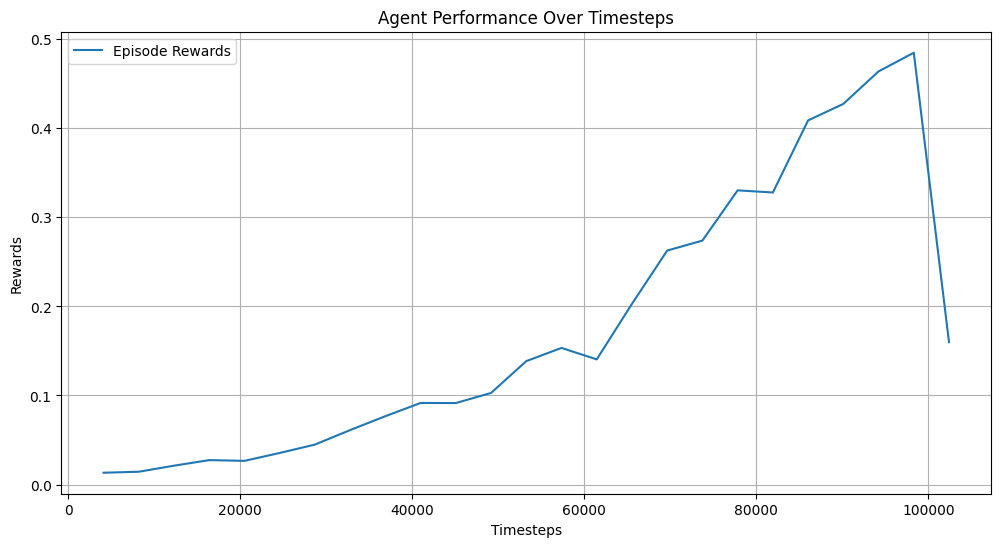

Performance for medium difficulty:


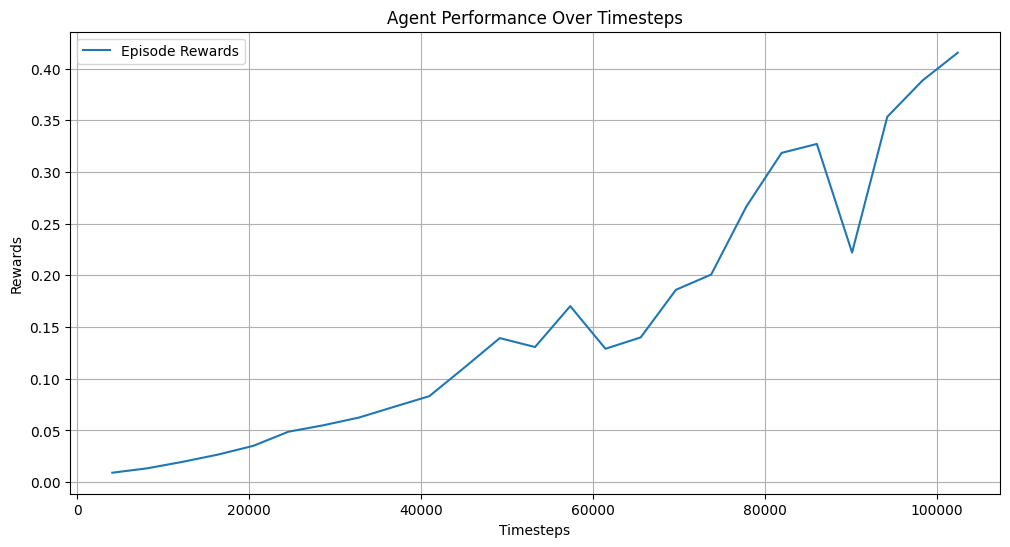

In [105]:
results, models, final_models = curriculum_experiment(difficulty_order, timesteps_per_difficulty=200_000, transfer=False)

In [109]:
difficulty_order

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['easy', 'medium']

In [95]:
models

[('easy', <stable_baselines3.ppo.ppo.PPO at 0x7c5e9ee93730>),
 ('medium', <stable_baselines3.ppo.ppo.PPO at 0x7c5ea2fad870>)]

In [119]:
model = models[0][1]

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


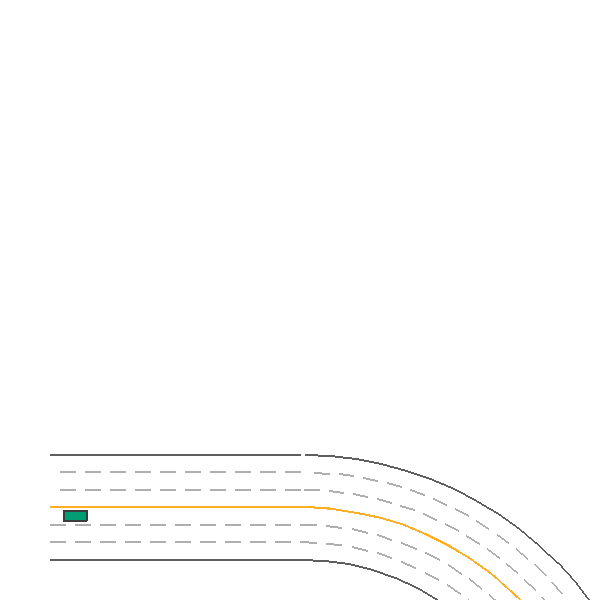

In [121]:
env = create_environment('easy', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

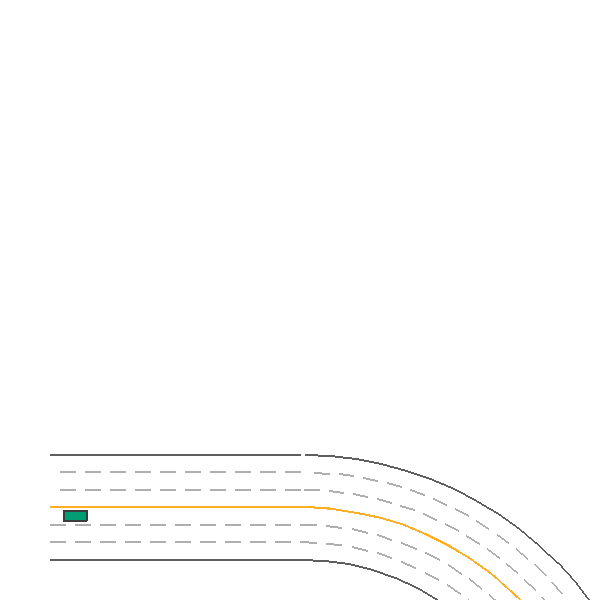

In [113]:
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

In [168]:
# prompt: load demo.dif and display it

import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
# %pip install git+https://github.com/metadriverse/metadrive.git
# !pip install stable-baselines3  # For PPO experiments
# !pip install gym  # Ensure gym is installed

# !apt-get install -y xvfb python-opengl ffmpeg

# !pip install pyvirtualdisplay

# !sudo apt-get update
# !sudo apt-get install -y xvfb

class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True

# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": render},
        "medium": {"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": render},
        "hard": {"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env
def train_agent_with_transfer(env, timesteps=1000, model=None, callbacks=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=32) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=callbacks)
    return model, logger
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=1000)
model = models[2][1]
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=32 and n_envs=1)
  warnings.warn(
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 38 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 53          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.016154574 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.687      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.056      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0329     |
|    std                  | 1      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 298          |
|    ep_rew_mean          | 8.75         |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 10           |
|    time_elapsed         | 4            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0060035065 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.0548      |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0079      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00929     |
|    std                  | 0.993        |
|    value_loss           | 0.0553       |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 219         |
|    ep_rew_mean          | 9.84        |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 14          |
|    time_elapsed         | 5           |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.008709554 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.00556     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0546      |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00808    |
|    std                  | 0.99        |
|    value_loss           | 0.185       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 6.3         |
| time/                   |             |
|    fps                  | 77          |
|    iterations           | 15          |
|    time_elapsed         | 6           |
|    total_timesteps      | 480         |
| train/                  |             |
|    approx_kl            | 0.009548064 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.000359    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.49        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0109     |
|    std                  | 0.989       |
|    value_loss           | 16.4        |
-----------------------------------------
-------------------------------------------
| rollout/                |     

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 142           |
|    ep_rew_mean          | 6.49          |
| time/                   |               |
|    fps                  | 77            |
|    iterations           | 18            |
|    time_elapsed         | 7             |
|    total_timesteps      | 576           |
| train/                  |               |
|    approx_kl            | 0.00039445795 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.82         |
|    explained_variance   | 0.00696       |
|    learning_rate        | 0.0003        |
|    loss                 | 0.225         |
|    n_updates            | 170           |
|    policy_gradient_loss | -0.00133      |
|    std                  | 0.989         |
|    value_loss           | 0.837         |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 5.11        |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 20          |
|    time_elapsed         | 7           |
|    total_timesteps      | 640         |
| train/                  |             |
|    approx_kl            | 0.013158517 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.000467    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0311     |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0339     |
|    std                  | 0.988       |
|    value_loss           | 0.0818      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 127          |
|    ep_rew_mean          | 7.28         |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 24           |
|    time_elapsed         | 9            |
|    total_timesteps      | 768          |
| train/                  |              |
|    approx_kl            | 0.0013251733 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.00625      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0314       |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00104     |
|    std                  | 0.988        |
|    value_loss           | 0.216        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 5.78        |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 25          |
|    time_elapsed         | 9           |
|    total_timesteps      | 800         |
| train/                  |             |
|    approx_kl            | 0.004310379 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000868   |
|    learning_rate        | 0.0003      |
|    loss                 | 7.2         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00725    |
|    std                  | 0.988       |
|    value_loss           | 14.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 90.8          |
|    ep_rew_mean          | 3.65          |
| time/                   |               |
|    fps                  | 80            |
|    iterations           | 26            |
|    time_elapsed         | 10            |
|    total_timesteps      | 832           |
| train/                  |               |
|    approx_kl            | 0.00055882335 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | 2.6e-05       |
|    learning_rate        | 0.0003        |
|    loss                 | 6.87          |
|    n_updates            | 250           |
|    policy_gradient_loss | 0.00309       |
|    std                  | 0.988         |
|    value_loss           | 14.5          |
-------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.7        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 27          |
|    time_elapsed         | 10          |
|    total_timesteps      | 864         |
| train/                  |             |
|    approx_kl            | 7.13449e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 6.88e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 9.04        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.000815   |
|    std                  | 0.988       |
|    value_loss           | 19.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 79.4         |
|    ep_rew_mean          | 2.58         |
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 28           |
|    time_elapsed         | 11           |
|    total_timesteps      | 896          |
| train/                  |              |
|    approx_kl            | 0.0068095196 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 1.85e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.52         |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00588     |
|    std                  | 0.99         |
|    value_loss           | 7.19         |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 11 |
|    iterations      | 1  |
|    time_elapsed    | 2  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.012825621 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.00341    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0379     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.027      |
|    std                  | 1    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 289          |
|    ep_rew_mean          | 7.77         |
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 10           |
|    time_elapsed         | 10           |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0021508522 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.025        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.105        |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00293     |
|    std                  | 0.997        |
|    value_loss           | 0.297        |
------------------------------------------
-----------------------------------------
| rollout/  

KeyboardInterrupt: 

In [ ]:
env = MetaDriveEnv( {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})

e = Monitor(env)
dir(e)
e.render(mode="topdown",
                    window=False,
                    screen_size=(600, 600),
                    camera_position=(50, 50))

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


TypeError: render() got an unexpected keyword argument 'mode'

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


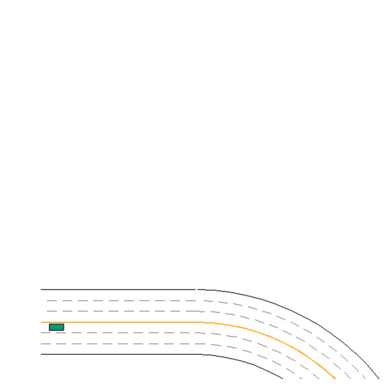

In [ ]:
try:
    env.close()
except:
    pass
total_reward = 0
env = MetaDriveEnv( {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
model = PPO("MlpPolicy",
            train_env,
            n_steps=4096,
            verbose=1)
try:
    e = Monitor(env)
    env = e.unwrapped
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
plt.axis("off")
plt.imshow(ret)

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
from metadrive.envs import MetaDriveEnv
from metadrive.policy.lange_change_policy import LaneChangePolicy
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from metadrive.component.map.base_map import BaseMap
from metadrive.utils import generate_gif
from IPython.display import Image

def create_env(need_monitor=False):
    env = MetaDriveEnv(dict(map="C",
                      # This policy setting simplifies the task
                      discrete_action=True,
                      discrete_throttle_dim=3,
                      discrete_steering_dim=3,
                      horizon=500,
                      # scenario setting
                      random_spawn_lane_index=False,
                      num_scenarios=1,
                      start_seed=5,
                      traffic_density=0,
                      accident_prob=0,
                      log_level=50))
    if need_monitor:
        env = Monitor(env)
    return env

In [ ]:
env.close()

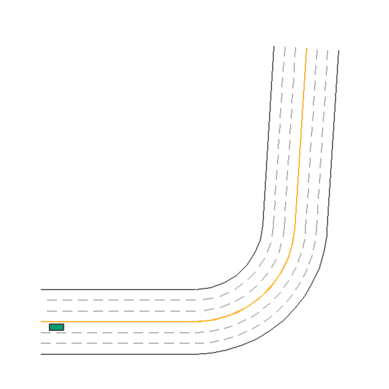

In [ ]:
env=create_env()
env.reset()
ret = env.render(mode="topdown",
                 window=False,
                 screen_size=(600, 600),
                 camera_position=(50, 50))
env.close()
plt.axis("off")
plt.imshow(ret)

In [ ]:
timesteps_per_difficulty=1000
difficulty = "easy"
results = []
env = create_environment(difficulty, render=False)
try:
    model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
    results.append((difficulty, logger))
    obs, _ = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

In [ ]:
try:
    env.close()
except:
    pass
env = create_environment("easy", render=False)
try:
    env.reset()
    ret = env.render(
        mode="topdown",
                    window=False,
                    screen_size=(600, 600),
                    camera_position=(50, 50))
finally:
    env.close()
plt.axis("off")
plt.imshow(ret)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3


Exception: Attempt to spawn multiple ShowBase instances!

In [ ]:
env = create_environment(difficulty, render=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3


Exception: Attempt to spawn multiple ShowBase instances!

: 

In [ ]:
timesteps_per_difficulty=1000
difficulty = "easy"
results = []
env = create_environment(difficulty, render=False)
try:
    model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
    results.append((difficulty, logger))
    obs, _ = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 72 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.008032592 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.349      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00238    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0067     |
|    std                  | 1           |
|    value_loss           | 0.0184    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 302        |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 138        |
|    iterations           | 10         |
|    time_elapsed         | 2          |
|    total_timesteps      | 320        |
| train/                  |            |
|    approx_kl            | 0.00643057 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85      |
|    explained_variance   | 0.018      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0637     |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0171    |
|    std                  | 1          |
|    value_loss           | 0.423      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 168          |
|    ep_rew_mean          | 1.37         |
| time/                   |              |
|    fps                  | 137          |
|    iterations           | 11           |
|    time_elapsed         | 2            |
|    total_timesteps      | 352          |
| train/                  |              |
|    approx_kl            | 0.0039157253 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.014        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.66         |
|    n_updates            | 100          |
|    policy_gradient_loss | 0.000467     |
|    std                  | 1            |
|    value_loss           | 10.5         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 159          |
|    ep_rew_mean          | 5.33         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 15           |
|    time_elapsed         | 3            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0030155852 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.00127     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.365        |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.0033       |
|    std                  | 1            |
|    value_loss           | 1.48         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | 4.76         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 18           |
|    time_elapsed         | 4            |
|    total_timesteps      | 576          |
| train/                  |              |
|    approx_kl            | 0.0034488663 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0286       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0975       |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00735     |
|    std                  | 1            |
|    value_loss           | 0.394        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 125          |
|    ep_rew_mean          | 5.35         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 20           |
|    time_elapsed         | 5            |
|    total_timesteps      | 640          |
| train/                  |              |
|    approx_kl            | 0.0008909926 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.027        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.48         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.998        |
|    value_loss           | 3.33         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | 5.81         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 22           |
|    time_elapsed         | 5            |
|    total_timesteps      | 704          |
| train/                  |              |
|    approx_kl            | 0.0001265388 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0323       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.52         |
|    n_updates            | 210          |
|    policy_gradient_loss | 0.00123      |
|    std                  | 0.998        |
|    value_loss           | 7.49         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 107          |
|    ep_rew_mean          | 5.96         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 24           |
|    time_elapsed         | 6            |
|    total_timesteps      | 768          |
| train/                  |              |
|    approx_kl            | 5.484186e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0395       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.4          |
|    n_updates            | 230          |
|    policy_gradient_loss | 0.00127      |
|    std                  | 0.997        |
|    value_loss           | 5.14         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | 6.01         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 26           |
|    time_elapsed         | 6            |
|    total_timesteps      | 832          |
| train/                  |              |
|    approx_kl            | 0.0036225468 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00138     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.483        |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.0129      |
|    std                  | 0.996        |
|    value_loss           | 1.18         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 94.9         |
|    ep_rew_mean          | 5.09         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 27           |
|    time_elapsed         | 6            |
|    total_timesteps      | 864          |
| train/                  |              |
|    approx_kl            | 0.0045335162 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00952      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.1          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00401     |
|    std                  | 0.995        |
|    value_loss           | 10.5         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 92.6         |
|    ep_rew_mean          | 5.17         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 29           |
|    time_elapsed         | 7            |
|    total_timesteps      | 928          |
| train/                  |              |
|    approx_kl            | 0.0020335894 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0086       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09         |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00786     |
|    std                  | 0.995        |
|    value_loss           | 2.35         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 90.8          |
|    ep_rew_mean          | 5.42          |
| time/                   |               |
|    fps                  | 125           |
|    iterations           | 32            |
|    time_elapsed         | 8             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.1753291e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | 0.016         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.03          |
|    n_updates            | 310           |
|    policy_gradient_loss | 0.00171       |
|    std                  | 0.994         |
|    value_loss           | 4.92          |
-------------------------------------------


TypeError: render() got an unexpected keyword argument 'mode'

In [ ]:
Image(open("demo.gif", 'rb').read())

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITHOUT Transfer Learning...
Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 85 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0148714315 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.188       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0521      |
|    n_updates            | 10           |
|  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | -2.39        |
| time/                   |              |
|    fps                  | 132          |
|    iterations           | 4            |
|    time_elapsed         | 0            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0052361134 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0162       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00911      |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.0128      |
|    std                  | 1            |
|    value_loss           | 0.0938       |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 93           |
|    ep_rew_mean          | -1.88        |
| time/                   |              |
|    fps                  | 139          |
|    iterations           | 6            |
|    time_elapsed         | 1            |
|    total_timesteps      | 192          |
| train/                  |              |
|    approx_kl            | 0.0014298856 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0149       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.197        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00165     |
|    std                  | 1            |
|    value_loss           | 0.651        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 89.3       |
|    ep_rew_mean          | -1.39      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 9          |
|    time_elapsed         | 1          |
|    total_timesteps      | 288        |
| train/                  |            |
|    approx_kl            | 0.01488691 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0141     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0282     |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.011     |
|    std                  | 0.997      |
|    value_loss           | 0.132      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 86.8          |
|    ep_rew_mean          | -1.56         |
| time/                   |               |
|    fps                  | 151           |
|    iterations           | 11            |
|    time_elapsed         | 2             |
|    total_timesteps      | 352           |
| train/                  |               |
|    approx_kl            | 0.00013663061 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | -0.0243       |
|    learning_rate        | 0.0003        |
|    loss                 | 0.114         |
|    n_updates            | 100           |
|    policy_gradient_loss | 0.00204       |
|    std                  | 0.997         |
|    value_loss           | 0.31          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 82.4         |
|    ep_rew_mean          | -1.72        |
| time/                   |              |
|    fps                  | 150          |
|    iterations           | 13           |
|    time_elapsed         | 2            |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0034064613 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00214     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0628       |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00817     |
|    std                  | 0.999        |
|    value_loss           | 0.218        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.4         |
|    ep_rew_mean          | -2.39        |
| time/                   |              |
|    fps                  | 145          |
|    iterations           | 14           |
|    time_elapsed         | 3            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0026339982 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00171      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.54         |
|    n_updates            | 130          |
|    policy_gradient_loss | 0.00655      |
|    std                  | 1            |
|    value_loss           | 3.36         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.2         |
|    ep_rew_mean          | -2.25        |
| time/                   |              |
|    fps                  | 146          |
|    iterations           | 16           |
|    time_elapsed         | 3            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0056114886 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00232      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.112        |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00918     |
|    std                  | 1            |
|    value_loss           | 0.292        |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 23 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 36          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.007510271 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.528      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00742    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00721    |
|    std                  | 1    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 272          |
|    ep_rew_mean          | 5.74         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 9            |
|    time_elapsed         | 5            |
|    total_timesteps      | 288          |
| train/                  |              |
|    approx_kl            | 0.0039082877 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.0291      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.151        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00623     |
|    std                  | 1.01         |
|    value_loss           | 0.845        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 127          |
|    ep_rew_mean          | 2.25         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 12           |
|    time_elapsed         | 7            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0019683018 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.00483      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.211        |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00663     |
|    std                  | 1            |
|    value_loss           | 1.08         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.2        |
|    ep_rew_mean          | 0.348       |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 14          |
|    time_elapsed         | 9           |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.012951184 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.0506      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00423     |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0305     |
|    std                  | 1           |
|    value_loss           | 0.177       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 77           |
|    ep_rew_mean          | -0.327       |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 15           |
|    time_elapsed         | 9            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0053646453 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.000731    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.69         |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.0163       |
|    std                  | 1            |
|    value_loss           | 20.5         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.9         |
|    ep_rew_mean          | -0.914       |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 16           |
|    time_elapsed         | 10           |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0013963338 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.000168    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.77         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00359     |
|    std                  | 1            |
|    value_loss           | 10.7         |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 12 |
|    iterations      | 1  |
|    time_elapsed    | 2  |
|    total_timesteps | 32 |
---------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 64         |
| train/                  |            |
|    approx_kl            | 0.00767746 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.193     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0201    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0141    |
|    std                  | 1          |
|    value

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 311         |
|    ep_rew_mean          | 11.7        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 10          |
|    time_elapsed         | 15          |
|    total_timesteps      | 320         |
| train/                  |             |
|    approx_kl            | 0.010824438 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0422     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00215    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00855    |
|    std                  | 0.998       |
|    value_loss           | 0.232       |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 218        |
|    ep_rew_mean          | 8.5        |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 14         |
|    time_elapsed         | 21         |
|    total_timesteps      | 448        |
| train/                  |            |
|    approx_kl            | 0.01331882 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0124     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0174    |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.997      |
|    value_loss           | 0.0571     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

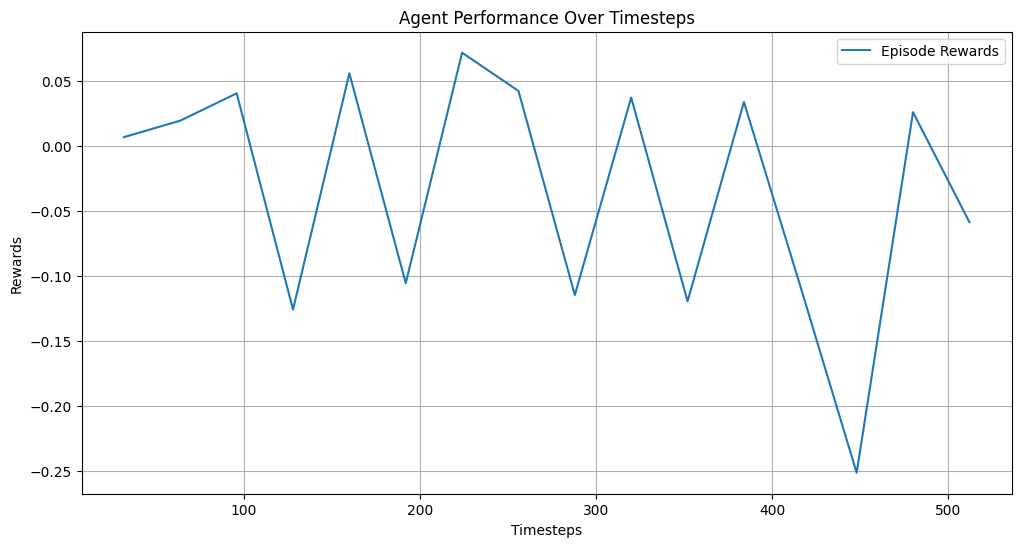

Performance for medium difficulty:


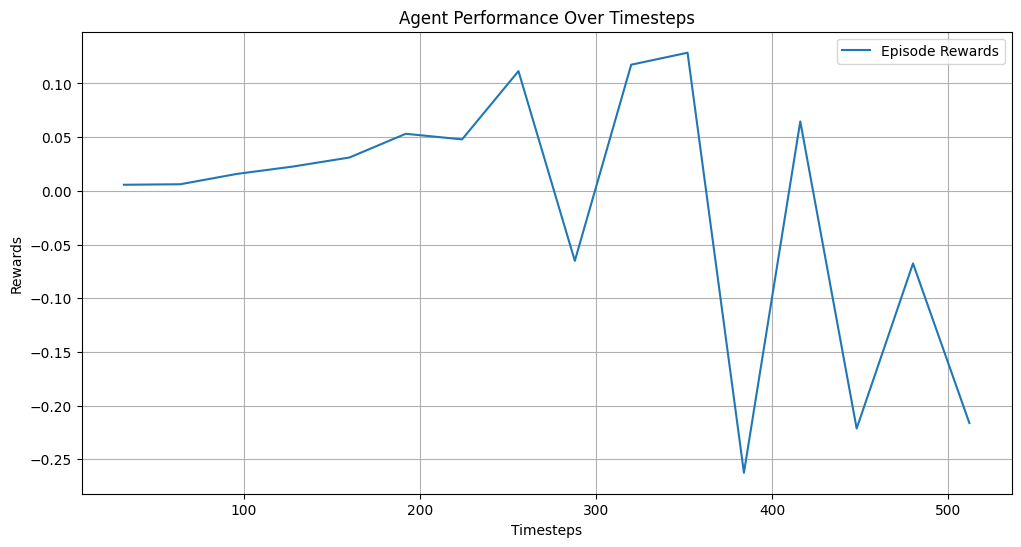

Performance for hard difficulty:


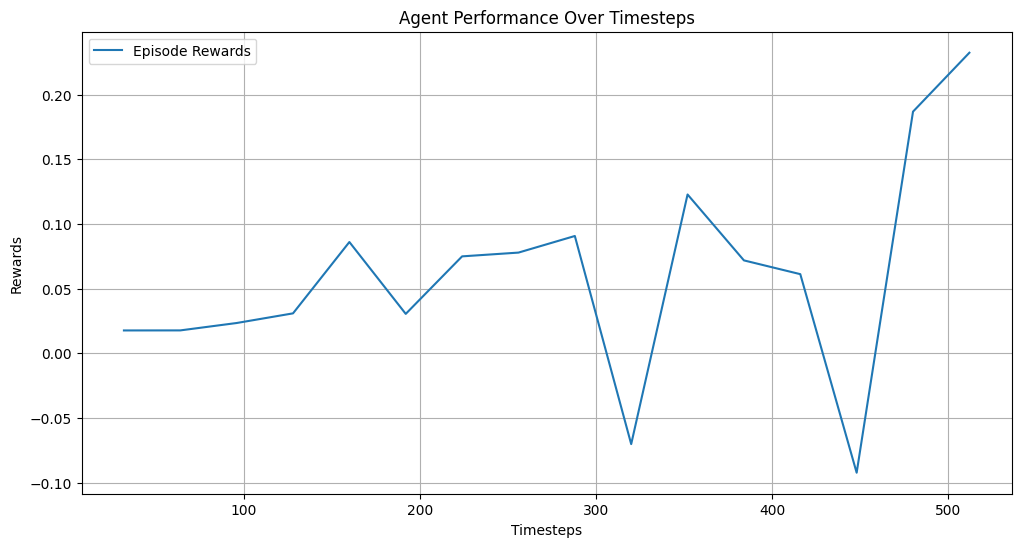

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITH Transfer Learning...
Training on easy difficulty (With Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 62 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.008222368 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.348      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0176     |
|    n_updates            | 10          |
|    policy_gradien

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 301          |
|    ep_rew_mean          | 3.18         |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 10           |
|    time_elapsed         | 2            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0077716317 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0139       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00773     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0127      |
|    std                  | 0.995        |
|    value_loss           | 0.0644       |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | 0.558        |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 12           |
|    time_elapsed         | 3            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0016949177 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00263      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0542       |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00246     |
|    std                  | 0.994        |
|    value_loss           | 0.255        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | -1.57        |
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 13           |
|    time_elapsed         | 3            |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0011942256 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00094      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.17         |
|    n_updates            | 120          |
|    policy_gradient_loss | 0.0013       |
|    std                  | 0.994        |
|    value_loss           | 6.95         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.6         |
|    ep_rew_mean          | -1.75        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 16           |
|    time_elapsed         | 4            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0001023002 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.00488      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0373       |
|    n_updates            | 150          |
|    policy_gradient_loss | -3.09e-05    |
|    std                  | 0.991        |
|    value_loss           | 0.125        |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 67 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.006417265 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.00509    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.164       |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0166     |
|    std                  | 0.988    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | 9.61        |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 6           |
|    time_elapsed         | 1           |
|    total_timesteps      | 192         |
| train/                  |             |
|    approx_kl            | 0.010501722 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000542   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.383       |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.989       |
|    value_loss           | 1.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 7           |
|    time_elapsed         | 2           |
|    total_timesteps      | 224         |
| train/                  |             |
|    approx_kl            | 0.021476252 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.000778    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.44        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.99        |
|    value_loss           | 6.94        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75.8        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 12          |
|    time_elapsed         | 4           |
|    total_timesteps      | 384         |
| train/                  |             |
|    approx_kl            | 0.004140351 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0121      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.263       |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.989       |
|    value_loss           | 1.1         |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 70           |
|    ep_rew_mean          | 2.97         |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 14           |
|    time_elapsed         | 4            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0052017495 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00854     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0649       |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.0107      |
|    std                  | 0.986        |
|    value_loss           | 0.263        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.9        |
|    ep_rew_mean          | 1.99        |
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 15          |
|    time_elapsed         | 5           |
|    total_timesteps      | 480         |
| train/                  |             |
|    approx_kl            | 0.012044935 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000261   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.74        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0172     |
|    std                  | 0.986       |
|    value_loss           | 9.58        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 69 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0010298584 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0012       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.212        |
|    n_updates            | 330          |
|    policy_gradient_loss | 0.00292      |
|    std               

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 116           |
|    ep_rew_mean          | 16.2          |
| time/                   |               |
|    fps                  | 85            |
|    iterations           | 4             |
|    time_elapsed         | 1             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 0.00039777532 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | 0.00527       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23          |
|    n_updates            | 350           |
|    policy_gradient_loss | -0.00295      |
|    std                  | 0.984         |
|    value_loss           | 3.27          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 96           |
|    ep_rew_mean          | 14.2         |
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 6            |
|    time_elapsed         | 2            |
|    total_timesteps      | 192          |
| train/                  |              |
|    approx_kl            | 0.0016509015 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00371     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.681        |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.005       |
|    std                  | 0.985        |
|    value_loss           | 1.55         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.3         |
|    ep_rew_mean          | 13.4         |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 10           |
|    time_elapsed         | 3            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0008036997 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00051     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.985        |
|    value_loss           | 2.57         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 88          |
|    ep_rew_mean          | 12.6        |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 11          |
|    time_elapsed         | 3           |
|    total_timesteps      | 352         |
| train/                  |             |
|    approx_kl            | 0.005817162 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000258   |
|    learning_rate        | 0.0003      |
|    loss                 | 6.9         |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.982       |
|    value_loss           | 13.8        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.4        |
|    ep_rew_mean          | 11.1        |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 13          |
|    time_elapsed         | 4           |
|    total_timesteps      | 416         |
| train/                  |             |
|    approx_kl            | 0.001254417 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.00475     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.28        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.000612   |
|    std                  | 0.981       |
|    value_loss           | 2.62        |
-----------------------------------------
-------------------------------------------
| rollout/                |     

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 85            |
|    ep_rew_mean          | 12.2          |
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 16            |
|    time_elapsed         | 5             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00036948547 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.8          |
|    explained_variance   | 0.000629      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.08          |
|    n_updates            | 470           |
|    policy_gradient_loss | -0.000256     |
|    std                  | 0.98          |
|    value_loss           | 4.64          |
-------------------------------------------
Performance for easy difficulty:

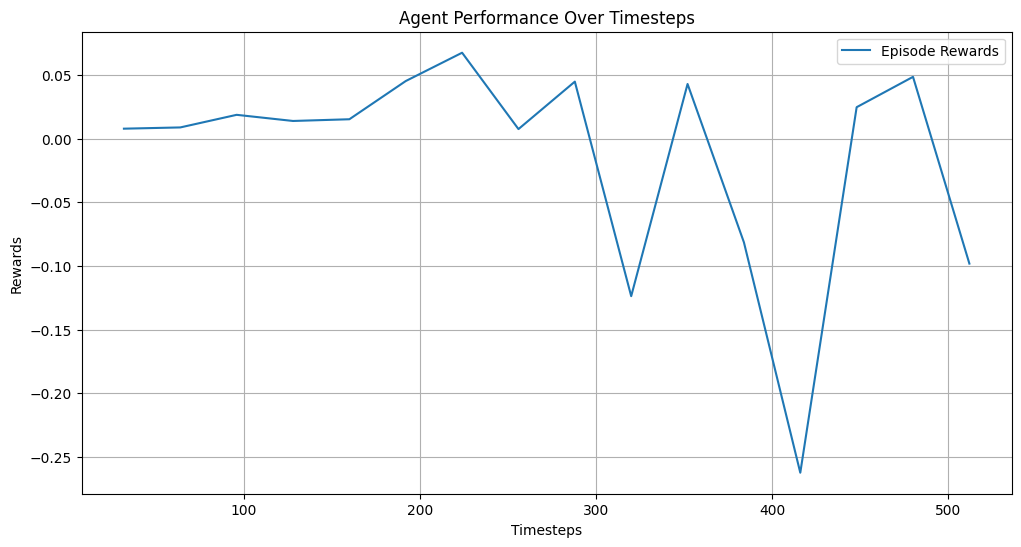

Performance for medium difficulty:


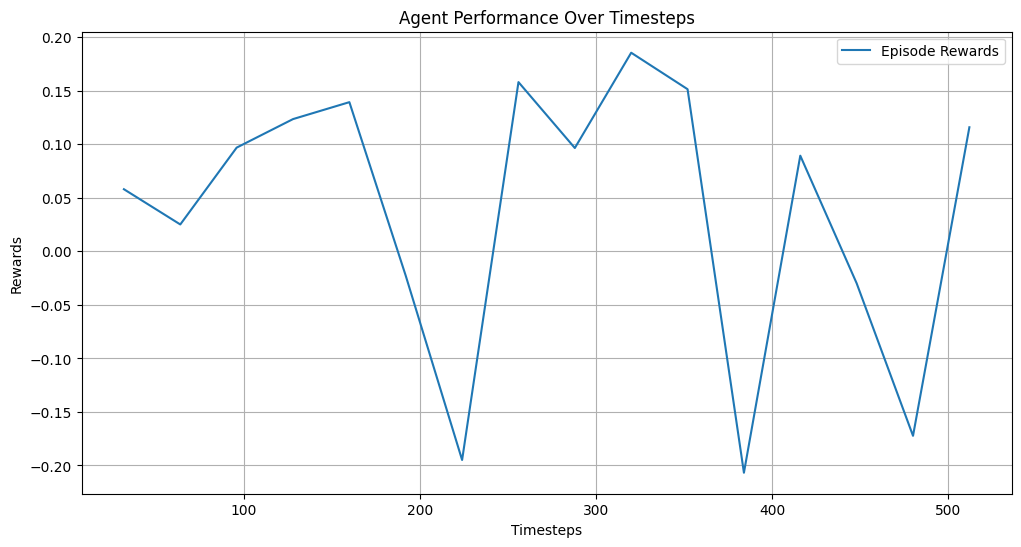

Performance for hard difficulty:


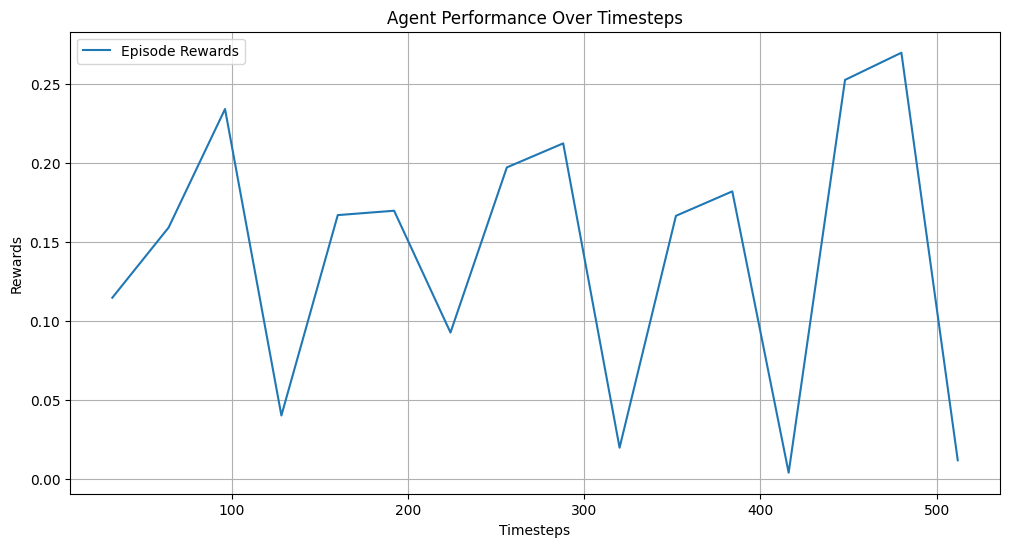

In [ ]:
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
print("Running Curriculum Experiment WITHOUT Transfer Learning...")
curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# Experiment with transfer learning
print("Running Curriculum Experiment WITH Transfer Learning...")
curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

# Code for simulator, not tested

In [ ]:
from pyvirtualdisplay import Display

# Set up the virtual display
display = Display(visible=0, size=(972, 729))
display.start()

In [ ]:
def show_frame(env, step, interval=10):
    if step % interval == 0:  # Show every 'interval' steps
        base_env = env.unwrapped  # Access the underlying MetaDriveEnv
        frame = base_env.render(mode="rgb_array")
        if frame is None:
            print("[WARNING] Frame rendering failed. Ensure 'use_render=True' in the configuration.")
            return
        img = Image.fromarray(frame)
        clear_output(wait=True)
        display(img)

In [ ]:
def reset_environment(env, difficulty):
    base_env = env.unwrapped
    if difficulty == "easy":
        base_env.config.update({"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
    elif difficulty == "medium":
        base_env.config.update({"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": False})
    elif difficulty == "hard":
        base_env.config.update({"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": False})
    base_env.reset()


In [ ]:
def evaluate_model_with_visualization(model, env, num_episodes=5):
  rewards = []
  for episode in range(num_episodes):
      obs, _ = env.reset()
      done = False
      total_reward = 0
      step = 0
      while not done:
          action, _ = model.predict(obs, deterministic=True)
          obs, reward, done, truncated, info = env.step(action)
          total_reward += reward
          show_frame(env, step)  # Display the frame every few steps
          step += 1
      rewards.append(total_reward)
  return rewards

SyntaxError: incomplete input (<ipython-input-14-59946a11ebd1>, line 1)

In [ ]:
def evaluate_and_save_video(model, env, num_episodes=1, output_dir="./video"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    frames = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            frame = env.unwrapped.render(mode="rgb_array")
            if frame is not None:
                frames.append(Image.fromarray(frame))
        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    # Save video as GIF
    video_path = os.path.join(output_dir, "evaluation.gif")
    frames[0].save(
        video_path,
        save_all=True,
        append_images=frames[1:],
        duration=50,  # Duration of each frame in milliseconds
        loop=0,
    )
    print(f"Video saved at: {video_path}")

In [ ]:
def curriculum_experiment_reuse_env(order):
    """
    Runs a curriculum learning experiment using a single reusable environment.
    """
    results = []
    env = create_environment("easy", render=True)  # Use a single environment

    for difficulty in order:
        print(f"Training on {difficulty} difficulty...")
        reset_environment(env, difficulty)
        model = train_agent(env, timesteps=100)
        evaluate_and_save_video(model, env, num_episodes=1)  # Save video for 1 episode
        results.append((difficulty, [0]))  # Placeholder for rewards in quick test

    env.close()
    return results

In [ ]:
def summarize_results(results):
    """
    Summarizes the results of the experiment.
    """
    for difficulty, rewards in results:
        avg_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        print(f"Difficulty: {difficulty}, Avg Reward: {avg_reward:.2f}, Std Dev: {std_reward:.2f}")

results = curriculum_experiment_reuse_env(["easy", "medium", "hard"])
summarize_results(results)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3


Training on easy difficulty...


[INFO] Known Pipes: glxGraphicsPipe
[WARNING] Since your screen is too small (1080, 810), we resize the window to (972, 729). (engine_core.py:230)
[INFO] Start Scenario Index: 0, Num Scenarios : 1


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (With Transfer=False)...
Using device: cpu
Using cpu device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 199  |
|    iterations      | 1    |
|    time_elapsed    | 20   |
|    total_timesteps | 4096 |
-----------------------------
loggerrewards [0.013284770888442154]
Error during training on easy difficulty: Length mismatch: Expected axis has 1 elements, new values have 3 elements


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


Performance for easy difficulty:


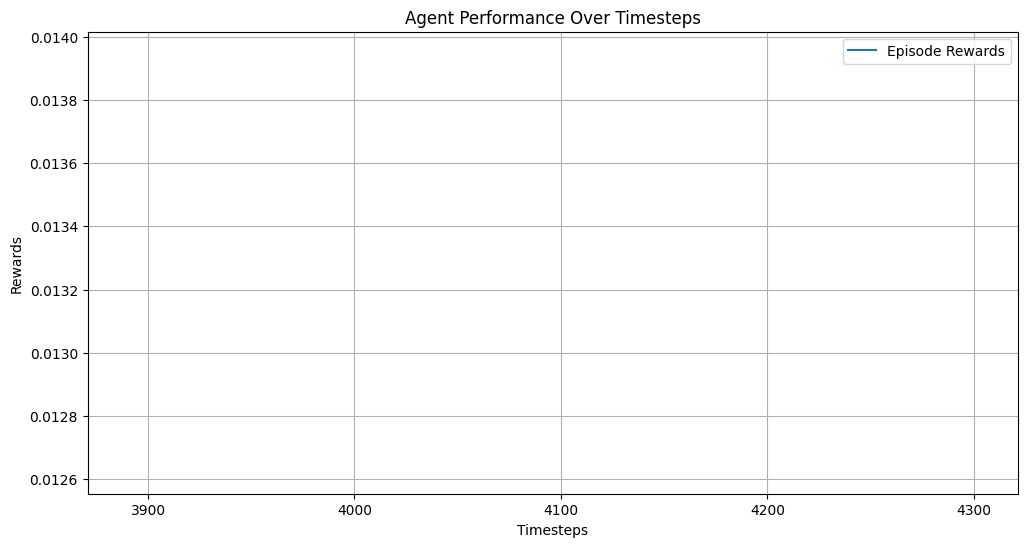

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer=False)...
Using device: cpu
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.95e+03 |
|    ep_rew_mean     | 17.7     |
| time/              |          |
|    fps             | 26       |
|    iterations      | 1        |
|    time_elapsed    | 154      |
|    total_timesteps | 4096     |
---------------------------------
loggerrewards [0.010942005631659119]
Error during training on medium difficulty: Length mismatch: Expected axis has 1 elements, new values have 3 elements


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


Performance for medium difficulty:


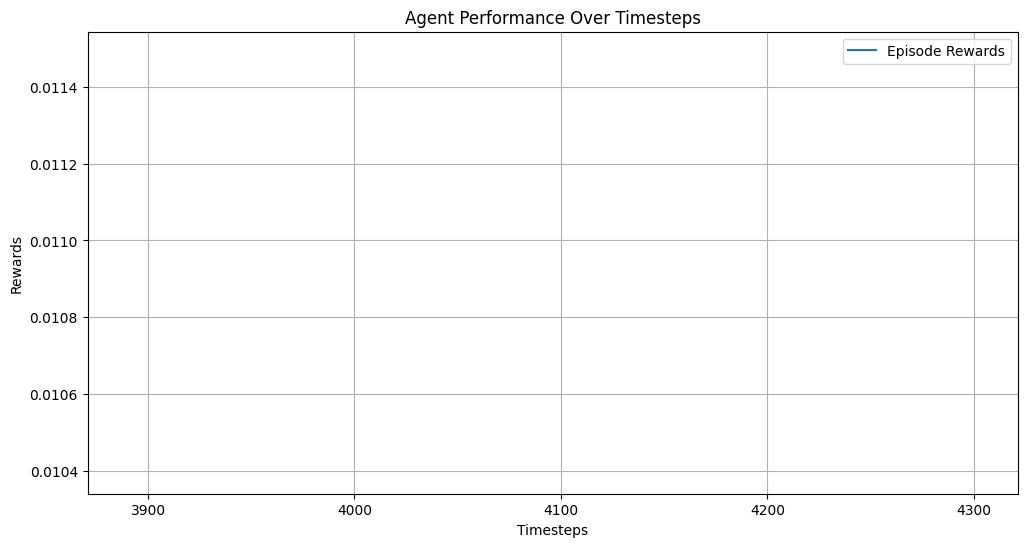

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer=False)...
Using device: cpu
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.96e+03 |
|    ep_rew_mean     | 20.4     |
| time/              |          |
|    fps             | 15       |
|    iterations      | 1        |
|    time_elapsed    | 261      |
|    total_timesteps | 4096     |
---------------------------------
loggerrewards [0.011696958981665617]
Error during training on hard difficulty: Length mismatch: Expected axis has 1 elements, new values have 3 elements


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


Performance for hard difficulty:


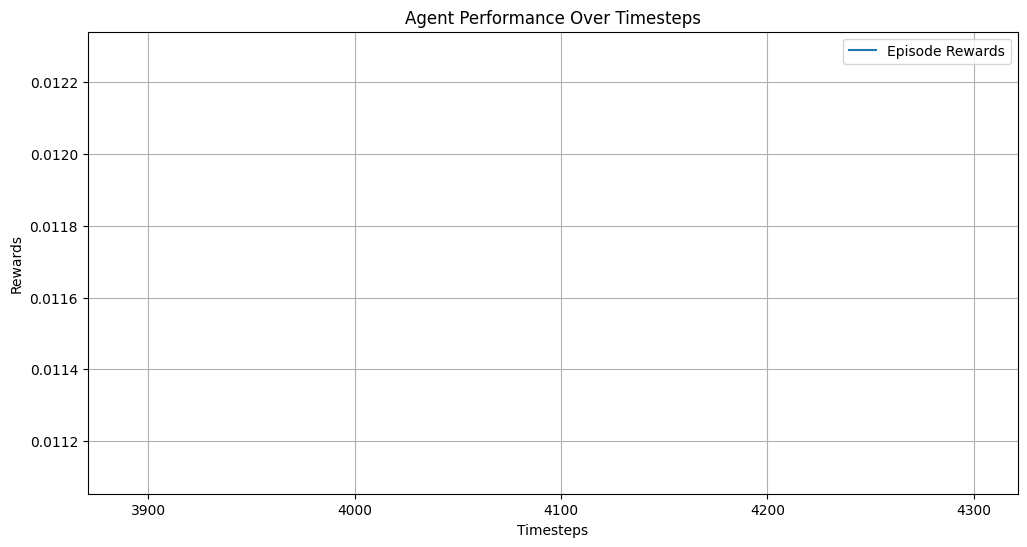

Uploaded trials/easy_med_hard_no_trans/test_rewards_post_training.csv to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/test_rewards_post_training.csv
Uploaded trials/easy_med_hard_no_trans/easy/best_model/training_rewards.png to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/easy/best_model/training_rewards.png
Uploaded trials/easy_med_hard_no_trans/easy/best_model/test_rewards_post_training.csv to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/easy/best_model/test_rewards_post_training.csv
Uploaded trials/easy_med_hard_no_trans/easy/gifs/demo.gif to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/easy/gifs/demo.gif
Uploaded trials/easy_med_hard_no_trans/easy/checkpoints/ppo_model_2800_steps.zip to gs://snap-chef-recipe/rl-final-project/easy_med_hard_no_trans/easy/checkpoints/ppo_model_2800_steps.zip
Uploaded trials/easy_med_hard_no_trans/easy/checkpoints/ppo_model_1000_steps.zip to gs://snap-chef-recipe/rl-final-project/easy_

In [39]:
# -*- coding: utf-8 -*-
"""RL_Final_Proj_Experiments.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/12pyLzKVljD3Sd6YfqWNZlaBp_ZEQw9bl
"""


# from google.colab import drive
# drive.mount('/content/drive')

# # Commented out IPython magic to ensure Python compatibility.
# # %pip install git+https://github.com/metadriverse/metadrive.git
# !pip install stable-baselines3  # For PPO experiments
# !pip install gym  # Ensure gym is installed

# !apt-get install -y xvfb python-opengl ffmpeg

# !pip install pyvirtualdisplay

# !sudo apt-get update
# !sudo apt-get install -y xvfb

import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from datetime import datetime
import torch
import pandas as pd
from google.cloud import storage
from IPython import display

from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback


class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0
        self.reward_dict = {}
        self.start_time = datetime.now()
        self.clock_duration = []

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0

    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(
                self.current_reward / self.model.n_steps
            )  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
            self.clock_duration.append(datetime.now() - self.start_time)
            # self.reward_dict[self.num_timesteps] = self.rewards[-1]
        return True


# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {
            "map": 2,
            "traffic_density": 0.0,
            "random_lane_width": False,
            "use_render": render,
            # "num_agents": 1,
            # "is_multi_agent": False
            #  "out_of_road_penalty": 30.0,  # Increased penalty
            #  "out_of_road_cost":
        },
        "medium": {
            "map": 3,
            "traffic_density": 0.3,
            "random_lane_width": True,
            "use_render": render,
            #  "out_of_road_penalty": 30.0,  # Increased penalty
        },
        "hard": {
            "map": 4,
            "traffic_density": 0.5,
            "random_lane_width": True,
            "use_render": render,
        },
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
        return base_env


def train_agent_with_transfer(
    env, timesteps=1000, model=None, callbacks=None, checkpoint_dir="./"
):
    if model is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        model = PPO(
            "MlpPolicy", env, verbose=2, n_steps=4096
        )  # changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger = PerformanceLogger()
    # model.learn(total_timesteps=100000, callback=checkpoint_callback)
    checkpoint_callback = CheckpointCallback(
        save_freq=200, save_path=checkpoint_dir, name_prefix="ppo_model"
    )
    logger.reset()
    # logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=[logger, checkpoint_callback])
    print("loggerrewards", logger.rewards)
    return model, logger


def plot_performance(logger, title="Agent Performance", save_path=None):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()

    # if save_path:
    plt.savefig(os.path.join(save_path, "training_rewards.png"))
    plt.show()


def init_dirs(trial_name, difficulty):
    trial_dir = os.path.join("trials", trial_name)
    log_dir = os.path.join(trial_name, difficulty, "logs")
    checkpoint_dir = os.path.join(trial_dir, difficulty, "checkpoints")
    best_model_dir = os.path.join(trial_dir, difficulty, "best_model")
    gif_dir = os.path.join(trial_dir, difficulty, "gifs")
    os.makedirs(trial_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(best_model_dir, exist_ok=True)
    os.makedirs(gif_dir, exist_ok=True)
    return trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir


def get_callbacks(checkpoint_dir, best_model_dir, log_dir, eval_env):
    logger = PerformanceLogger()
    # model.learn(total_timesteps=100000, callback=checkpoint_callback)
    checkpoint_callback = CheckpointCallback(
        save_freq=10_000, save_path=checkpoint_dir, name_prefix="ppo_model"
    )
    # TODO: get filepaths right
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=best_model_dir,
        log_path=log_dir,
        eval_freq=1000,  # Evaluate every 10,000 steps
        n_eval_episodes=5,  # Number of episodes per evaluation
        deterministic=True,
        render=False,
    )
    return eval_callback, checkpoint_callback, logger


def upload_folder_to_gcs(local_folder, bucket_name, gcs_prefix):
    """
    Uploads the contents of a local folder (including subdirectories) to a GCS bucket,
    preserving the folder structure under a given prefix.

    Args:
        local_folder (str): Path to the local folder.
        bucket_name (str): Name of the GCS bucket.
        gcs_prefix (str): Prefix for the uploaded files in the bucket.

    Returns:
        None
    """
    # Initialize the GCS client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Walk through the local folder
    for root, dirs, files in os.walk(local_folder):
        for file_name in files:
            # Get the full local path
            local_path = os.path.join(root, file_name)

            # Construct the relative path in GCS
            relative_path = os.path.relpath(local_path, local_folder)
            gcs_path = os.path.join(gcs_prefix, relative_path).replace(
                "\\", "/"
            )  # Ensure GCS path is POSIX-style

            # Upload the file
            blob = bucket.blob(gcs_path)
            blob.upload_from_filename(local_path)
            print(f"Uploaded {local_path} to gs://{bucket_name}/{gcs_path}")


def create_gif(env, model, gif_dir):
    obs, _ = env.reset()
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        if isinstance(env, Monitor):
            e = env.env
        else:
            e = env
        ret = e.render(
            mode="topdown",
            screen_record=True,
            window=False,
            screen_size=(600, 600),
            camera_position=(50, 50),
        )
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif(os.path.join(gif_dir, "demo.gif"))
    img = display.Image(filename=os.path.join(gif_dir, "demo.gif"))
    # display(img)
    return img


def run_trial(trial_name, difficulty, model, transfer, timesteps_per_difficulty):
    trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir = init_dirs(
        trial_name, difficulty
    )
    eval_env = create_environment(difficulty, render=False, monitor=False)

    print(f"Training on {difficulty} difficulty (With Transfer={transfer})...")
    env = create_environment(difficulty, render=False)
    try:
        eval_callback, checkpoint_callback, _ = get_callbacks(
            checkpoint_dir, best_model_dir, log_dir, eval_env
        )
        # try:
        #   x=evaluate_model(model, eval_env, num_episodes=10, max_timesteps_per_episode=1000)
        #   rews = pd.DataFrame(x)
        #   pd.to_csv(os.path.join(trial_dir, 'test_rewards_pre_training.csv'), index=False)
        # except Exception as e:
        #   print(f"Error during gif creation/test eval with ", e)
        model, logger = train_agent_with_transfer(
            env,
            model=model,
            timesteps=timesteps_per_difficulty,
            callbacks=[checkpoint_callback],  # eval_callback,
            checkpoint_dir=checkpoint_dir,
        )
        df = pd.DataFrame(logger.timesteps, logger.rewards, logger.clock_duration)
        df.columns = ["timesteps", "rewards", "duration"]
        df.to_csv(os.path.join(best_model_dir, "training_rewards.csv"))
        # model = PPO.load(os.path.join(best_model_dir, 'best_model'))
    except Exception as e:
        print(f"Error during training on {difficulty} difficulty: {e}")
    finally:
        env.close()
        try:
            create_gif(eval_env, model, gif_dir)
            x = evaluate_model(
                model, eval_env, num_episodes=10, max_timesteps_per_episode=1000
            )
            rews = pd.DataFrame(x)
            rews.to_csv(
                os.path.join(best_model_dir, "test_rewards_post_training.csv"),
                index=False,
            )
        except Exception as e:
            print(f"Error during gif creation/test eval with ", e)
        eval_env.close()
    # print("after trail rewards ", logger.rewards)
    # Plot performance for each difficulty
    # print(f"Performance for {difficulty} difficulty:"
    return logger, model, None


# Curriculum experiment with transfer learning
def curriculum_experiment(
    difficulty_order,
    timesteps_per_difficulty=1000,
    transfer=True,
    trial_name=None,
    model=None,
):
    if trial_name is None:
        trial_name = datetime.now().strftime("%Y%m%d-%H%M%S")
    results = []
    models = []
    final_models = []

    for difficulty in difficulty_order:
        trial_dir, log_dir, checkpoint_dir, best_model_dir, gif_dir = init_dirs(
            trial_name, difficulty
        )
        result, model, final_model = run_trial(
            trial_name, difficulty, model, transfer, timesteps_per_difficulty
        )
        results.append((difficulty, result))
        models.append((difficulty, model))
        final_models.append((difficulty, final_model))
        if transfer:
            model = final_model
        else:
            model = None
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(
            result,
            f"Performance on {difficulty} (With Transfer={transfer})",
            best_model_dir,
        )
    # Plot performance for each difficulty
    # for difficulty, logger in results:

    return results, models, final_models


def evaluate_model(model, env, num_episodes=10, max_timesteps_per_episode=1000):
    """
    Evaluate a trained model in the given environment.

    Parameters:
    - model: The trained RL model to evaluate.
    - env: The environment to evaluate the model in.
    - num_episodes: Number of episodes to run for evaluation.
    - max_timesteps_per_episode: Maximum timesteps per episode.

    Returns:
    - results: A list of dictionaries containing total reward and termination reason for each episode.
    """
    results = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        termination_reason = None
        for i in range(1_000):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            # total_reward += reward
            if isinstance(env, Monitor):
                e = env.env
            else:
                e = env
            ret = e.render(
                mode="topdown",
                screen_record=True,
                window=False,
                screen_size=(600, 600),
                camera_position=(50, 50),
            )

            if terminated or truncated:
                if info.get("arrive_dest", False):
                    termination_reason = "Destination Reached"
                elif info.get("crash", False):
                    termination_reason = "Collision"
                elif info.get("out_of_road", False):
                    termination_reason = "Off Road"
                else:
                    termination_reason = "Other"
                break

        results.append(
            {
                "episode": episode + 1,
                "total_reward": total_reward,
                "termination_reason": termination_reason,
            }
        )

    return results


def main(time_steps, difficulty_order):

    results, models, final_models = curriculum_experiment(
        difficulty_order,
        timesteps_per_difficulty=time_steps,
        transfer=False,
        trial_name="easy_med_hard_no_trans",
    )

    upload_folder_to_gcs("trials", "snap-chef-recipe", "rl-final-project")


if __name__ == "__main__":
    time_steps = 200
    difficulty_order = ["easy", "medium", "hard"]
    main(time_steps, difficulty_order)
